In [1]:
import os
if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/sompriya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import pandas as pd
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.timelagged import create_timelagged_dataset
from mlcolvar.data import DictModule


In [3]:
df = load_dataframe('COLVAR_d_modified',start=10000,stop=53474)
df

,time,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d37,d38,d39,d40,d41,d42,d43,d44,d45,walker
0,10000.0,0.392389,0.643247,0.368361,0.956505,0.588743,0.389670,1.191396,0.875998,0.548561,...,0.504187,0.628760,0.754295,1.078909,1.211991,0.989752,0.967835,0.632940,0.373359,0
1,10001.0,0.385662,0.650388,0.384583,0.965905,0.629827,0.392315,1.196320,0.894850,0.546030,...,0.518257,0.626979,0.734313,1.108188,1.197051,1.000869,0.993314,0.676668,0.387261,0
2,10002.0,0.389316,0.657818,0.373705,0.985132,0.631057,0.392199,1.190989,0.890433,0.536146,...,0.521309,0.629563,0.766120,1.124791,1.224905,0.995771,0.977189,0.667645,0.391991,0
3,10003.0,0.390518,0.725014,0.383483,0.963909,0.612614,0.386309,1.252555,0.898139,0.549086,...,0.505538,0.529010,0.713323,1.066365,1.243546,1.099141,0.956221,0.643240,0.381142,0
4,10004.0,0.389827,0.685110,0.392156,0.977513,0.619420,0.404297,1.259697,0.914889,0.584495,...,0.518194,0.607693,0.736601,1.107085,1.263972,1.055198,0.997846,0.672854,0.382122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43469,53469.0,0.372050,0.652299,0.383131,0.968485,0.717347,0.379189,1.199607,0.872496,0.608829,...,2.053482,1.685929,1.547273,1.415511,1.035565,0.919626,0.550515,0.531868,0.385676,0
43470,53470.0,0.378793,0.629969,0.382233,0.910182,0.669204,0.387331,1.230351,0.921246,0.685229,...,1.753109,1.994840,1.755906,1.387966,1.099405,0.983828,0.597416,0.618856,0.379985,0
43471,53471.0,0.378670,0.567548,0.397640,0.904640,0.685503,0.392542,1.119921,0.992560,0.684519,...,1.916516,1.977766,1.684247,1.512321,1.151438,1.036143,0.685646,0.598220,0.376864,0
43472,53472.0,0.388565,0.599068,0.376088,0.724633,0.618373,0.391806,0.577087,0.685595,0.617725,...,1.359507,1.630610,1.700778,1.452547,1.099980,0.932984,0.581299,0.530695,0.377565,0


In [4]:
# Select input features
X = df.filter(regex='d').values
n_input = X.shape[1]

print(X.shape)

(43474, 45)


In [5]:
#------------- PARAMETERS -------------
temp              = 300.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)

# Extract cvs from df

t = df['time'].values # save time
#bias = df.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
#logweights = 0 (for chignolin initial simulation is unbiased)

In [6]:
#------------- PARAMETERS -------------
lag_time = 1.
#--------------------------------------

# create dataset
dataset = create_timelagged_dataset(X,t,lag_time=lag_time,progress_bar=True)

# create datamodule (split train valid)
datamodule = DictModule(dataset,lengths=[0.8,0.2],random_split=False,shuffle=False)

datamodule

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43471/43471 [00:00<00:00, 389474.61it/s]
/home/sompriya/.local/lib/python3.10/site-packages/mlcolvar/utils/timelagged.py:186: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)
/home/sompriya/.local/lib/python3.10/site-packages/mlcolvar/data/datamodule.py:134: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


DictModule(dataset -> DictDataset( "data": [43471, 45], "data_lag": [43471, 45], "weights": [43471], "weights_lag": [43471] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=False),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=False))

In [7]:
from mlcolvar.cvs import DeepTICA

n_components = 2 # Eigen value of Second degree of freedom should be less one. If both comparable then both are imp
nn_layers = [45,30,30,5]
options= {'nn': {'activation': 'shifted_softplus'}}

model = DeepTICA(nn_layers, n_cvs=n_components, options=options)
model

DeepTICA(
  (loss_fn): ReduceEigenvaluesLoss()
  (norm_in): Normalization(in_features=45, out_features=45, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=45, out_features=30, bias=True)
      (1): Shifted_Softplus(beta=1, threshold=20)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Shifted_Softplus(beta=1, threshold=20)
      (4): Linear(in_features=30, out_features=5, bias=True)
    )
  )
  (tica): TICA(in_features=5, out_features=2)
)

In [8]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=100)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/sompriya/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/sompriya/.local/lib/python3.10/site-packages/lightning/pytorch/

Sanity Checking: |                                                                                            …

/home/sompriya/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

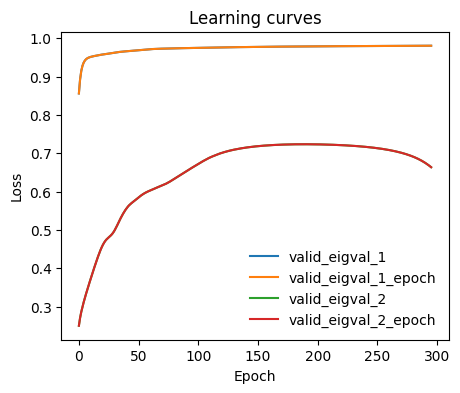

In [9]:
from mlcolvar.utils.plot import plot_metrics

ax = plot_metrics(metrics.metrics,
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

In [10]:
from mlcolvar.core.transform import Normalization
from mlcolvar.core.transform.utils import Statistics

#X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) )
model.postprocessing = norm

Text(0, 0.5, 'Deep-TICA 2')

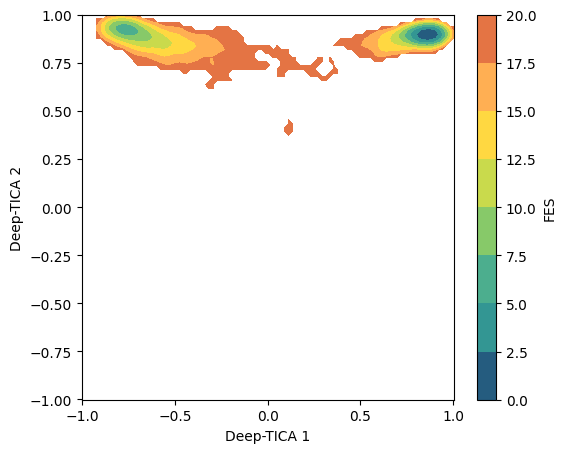

In [11]:
from mlcolvar.utils.fes import compute_fes

fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

#w = np.exp(logweights)
fes,grid,bounds,error = compute_fes(s,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, ax = ax, eps=1e-10)

ax.set_xlabel('Deep-TICA 1') #seperate minimas here
ax.set_ylabel('Deep-TICA 2')


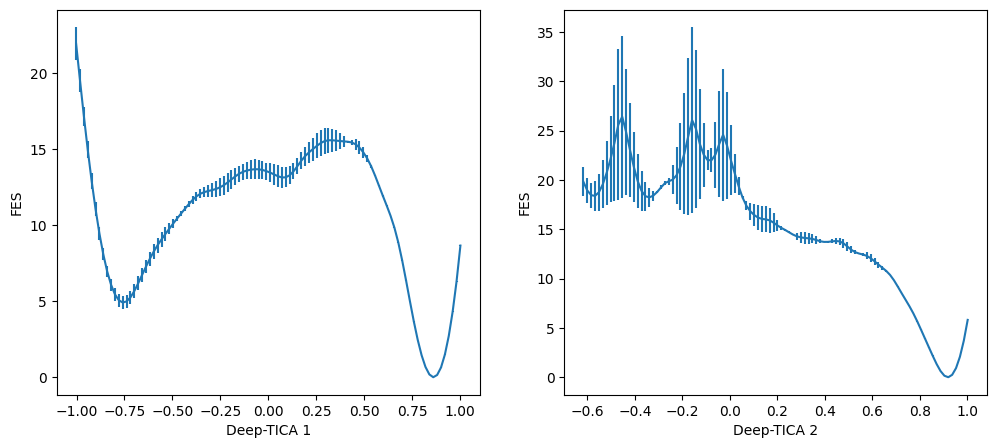

In [12]:
from mlcolvar.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(6*n_components,5),dpi=100)

for i in range(n_components):
    #w = np.exp(logweights)

    # restrict the second CV to the points in which the first is < 0
    fes,grid,bounds,error = compute_fes(s[:,i] if i == 0 else s[s[:,0] < 0, i ],
                                        #weights=w if i == 0 else w[s[:,0] < 0 ],
                                        blocks=2,
                                        bandwidth=0.02,scale_by='range',
                                        plot=True, plot_max_fes=100, ax = axs[i])
    axs[i].set_xlabel('Deep-TICA '+str(i+1))

In [13]:
## Save the model
x = torch.rand(n_input, dtype=torch.float32, requires_grad=True).unsqueeze(0)
traced_cv = torch.jit.trace ( model, example_inputs=x)
filename='chignolin3_deeptica.pt'
traced_cv.save(filename)

/home/sompriya/.local/lib/python3.10/site-packages/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()
/home/sompriya/.local/lib/python3.10/site-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is n

In [14]:
#Lasso Regression delete low weitage NN
from sklearn import linear_model
from sklearn.linear_model import LassoCV

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
tic0 = s[:,0]#select DeepTICA 1

reg = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X, tic0)
print(reg.coef_)
print(reg.intercept_)
np.savetxt('tica_coeff.txt',reg.coef_,fmt='%0.3f')

[-0.          0.         -0.         -0.         -0.64316476  0.
 -0.          0.         -0.         -0.          0.          0.89588421
 -1.41646183  0.94198067 -0.          0.34405296 -0.19678662  0.
 -0.93146583 -0.          0.          0.26399774 -0.         -0.07901104
  0.         -0.         -1.04307261  0.          0.         -0.95258533
  0.12531854  0.51200128  0.33447     0.52378502  0.         -0.
 -0.68024119  0.49961669 -0.03922349  0.         -0.         -0.12791925
  0.00680956  0.         -0.        ]
0.6402328645725688


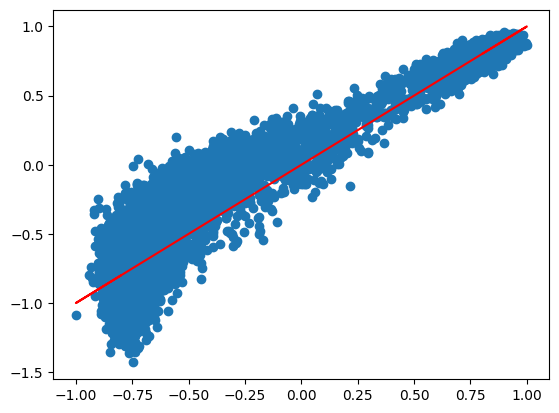

In [15]:
X_np = torch.Tensor(X).numpy()
ypred = reg.predict(X)

plt.scatter(tic0,ypred)
plt.plot(tic0,tic0,c='r') # X axis=DeepTICA 1 CV, Y axis= lassoCV, two states

In [16]:
s='lasso: COMBINE ARG='
for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        s+= 'd%d'%(i+1)
        if i < len(reg.coef_) - 1:
            s+= ','
s+= ' COEFFICIENTS='

for i in range(len(reg.coef_)):
    if reg.coef_[i] != 0:
        s+= '%0.4f'%reg.coef_[i]
        if i < len(reg.coef_) - 1:
            s+= ','
s+= ' PERIODIC=NO'
print(s)
print(' ')

#correct for offset
of_arr = ypred - np.dot(X_np,reg.coef_)
offset = of_arr[0]
if offset>0:
    s2 = 'lassoCV: MATHEVAL ARG=lasso FUNC=x+%0.4f PERIODIC=NO'%offset
elif offset<0:
    s2 = 'lassoCV: MATHEVAL ARG=lasso FUNC=x%0.4f PERIODIC=NO'%offset
print(s2)

lasso: COMBINE ARG=d5,d12,d13,d14,d16,d17,d19,d22,d24,d27,d30,d31,d32,d33,d34,d37,d38,d39,d42,d43, COEFFICIENTS=-0.6432,0.8959,-1.4165,0.9420,0.3441,-0.1968,-0.9315,0.2640,-0.0790,-1.0431,-0.9526,0.1253,0.5120,0.3345,0.5238,-0.6802,0.4996,-0.0392,-0.1279,0.0068, PERIODIC=NO
 
lassoCV: MATHEVAL ARG=lasso FUNC=x+0.6402 PERIODIC=NO
